In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

pd.set_option("display.max_columns", 100)

In [2]:
train = pd.read_csv("train_V2.csv")

test = pd.read_csv("test_V2.csv")

In [9]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


### Data fields:

**DBNOs** - Number of enemy players knocked. <br>
**assists** - Number of enemy players this player damaged that were killed by teammates.<br>
boosts - Number of boost items used.<br>
damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.<br>
headshotKills - Number of enemy players killed with headshots.<br>
heals - Number of healing items used.<br>
Id - Player’s Id<br>
killPlace - Ranking in match of number of enemy players killed.<br>
killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.<br>
killStreaks - Max number of enemy players killed in a short amount of time.<br>
kills - Number of enemy players killed.<br>
longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.<br>
matchDuration - Duration of match in seconds.<br>
matchId - ID to identify match. There are no matches that are in both the training and testing set.<br>
matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.<br>
rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.<br>
revives - Number of times this player revived teammates.<br>
rideDistance - Total distance traveled in vehicles measured in meters.<br>
roadKills - Number of kills while in a vehicle.<br>
swimDistance - Total distance traveled by swimming measured in meters.<br>
teamKills - Number of times this player killed a teammate.<br>
vehicleDestroys - Number of vehicles destroyed.<br>
walkDistance - Total distance traveled on foot measured in meters.<br>
weaponsAcquired - Number of weapons picked up.<br>
winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.<br>
groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.<br>
numGroups - Number of groups we have data for in the match.<br>
maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.<br>
winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.<br>

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


Looking at the types of all our columns, we see straightaway that most of our columns are numerical (either int64 or float64). This means they are all suitable for most prediction models we want to use. They also do not contain any missing values (will confirm this in a bit). 

The only object columns are Id, groupId, matchId and matchType. The first 3 are identifier columns, and can be excluded from the model. The last one, matchType will have to be explored further to see if we need to one-hot-encode it. 

In [5]:
train.matchType.value_counts()

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536762
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

Seems like we can one-hot-encode it, since there are not too many categories. 

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1934174 entries, 0 to 1934173
Data columns (total 28 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
dtypes: float64(5), int64(19), object(4)
memory usage: 413.2+ MB


In [10]:
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,2.299759e+01,1.579506e+03,4.450467e+01,4.300759e+01,8.920105e+02,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,5.097262e+01,2.587399e+02,2.382811e+01,2.328949e+01,7.366478e+02,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.367000e+03,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.438000e+03,3.000000e+01,3.000000e+01,1.443000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,2.132000e+01,1.851000e+03,4.900000e+01,4.700000e+01,1.500000e+03,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,1.094000e+03,2.237000e+03,1.000000e+02,1.000000e+02,5.910000e+03,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


## Chasing the Killers

In [71]:

print("The mean number of kills that each player makes is: {:.4f} people and max number of people killed by a player is {}".format(train.kills.mean(), train.kills.max()))

The mean number of kills that each player makes is: 0.9248 people and max number of people killed by a player is 72


### Visualizing the Kills

In [53]:
train.kills.value_counts()

0     2529722
1      928079
2      472466
3      232441
4      124543
5       66577
6       37960
7       21816
8       12779
9        7644
10       4599
11       2799
12       1755
13       1137
14        757
15        484
16        325
17        234
18        165
19        112
20        109
22         77
21         70
23         47
24         44
26         27
25         27
28         22
27         21
29         13
30         13
31         13
33         12
36          8
35          7
38          7
34          5
37          5
41          5
32          4
39          4
40          4
53          4
43          3
42          3
44          2
46          2
55          2
56          2
57          2
45          1
47          1
48          1
49          1
50          1
66          1
65          1
72          1
Name: kills, dtype: int64

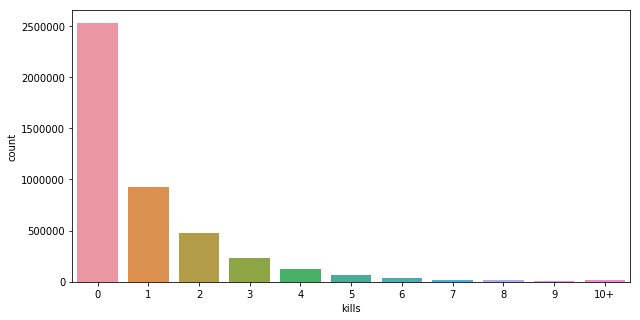

In [3]:
data = train.copy()

#replacing all kill values >10 with 10+ for purposes of visualization
data.loc[data['kills'] >= 10, 'kills'] = '10+' 

#plotting countplot
plt.figure(figsize=(10,5))
sns.countplot(data['kills'].astype('category'))
plt.show()

Most players dont kill anybody during the game. What is the distribution of the types of kills in the game? Let's remove the players with 0 overall kills to visualize a little better.

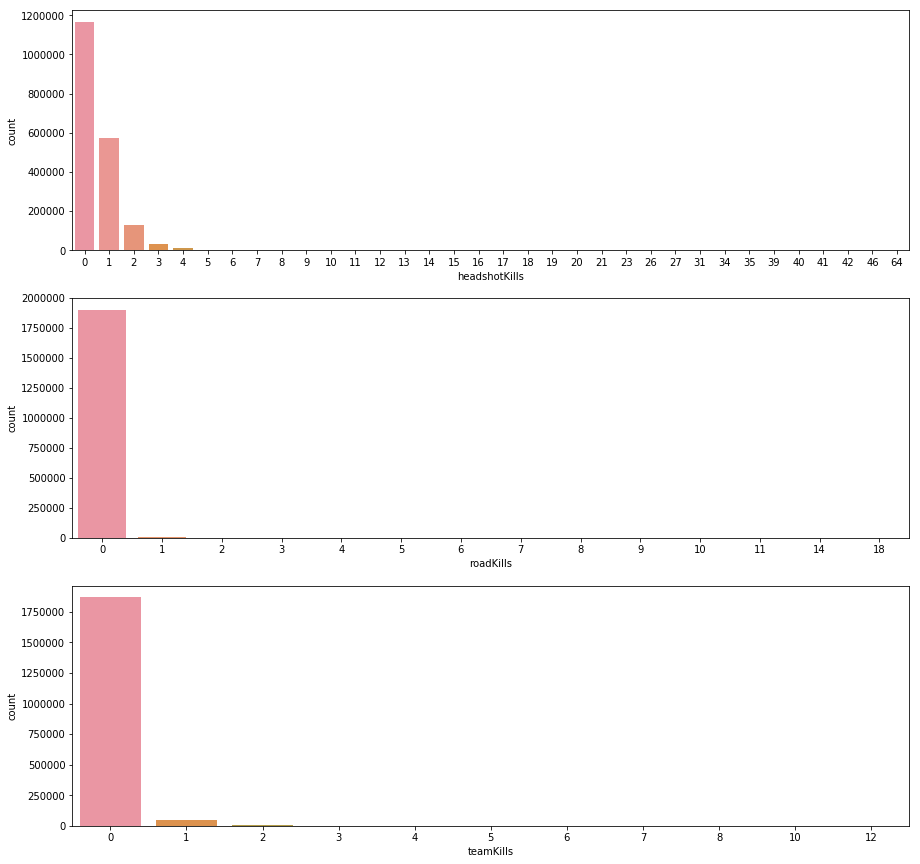

In [30]:
data = train.copy()
data = data.loc[data['kills']>0]


fig, ax = plt.subplots(3,1,figsize=(15,15))

sns.countplot(data['headshotKills'], ax=ax[0])

sns.countplot(data['roadKills'], ax=ax[1])

sns.countplot(data['teamKills'], ax=ax[2])

plt.show()

Do these different type of kills usually occur with each other? Or are they independent of each other?

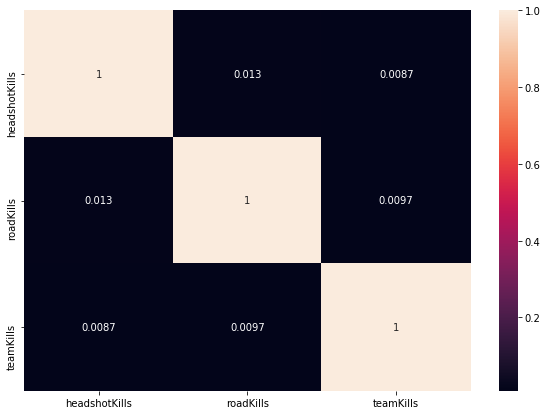

In [3]:
data = train.copy()
data = data.loc[:, ['headshotKills', 'roadKills', 'teamKills']]

plt.figure(figsize=(10,7))
sns.heatmap(data.corr(), annot=True)
plt.show()

There is very little correlation between the different types of kills, suggesting most players kill only one way. 

Now, most players kill 0 people. Let's now explore how number of Kills relates to the Winning Percentage.

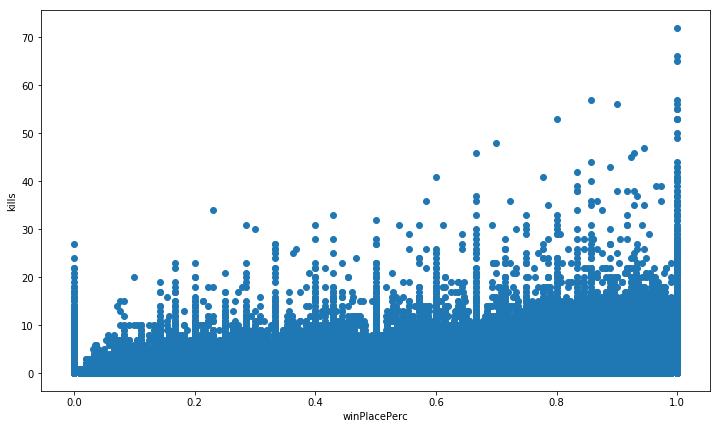

In [16]:
plt.figure(figsize=(12,7))
plt.scatter(x='winPlacePerc', y='kills', data = train)
plt.xlabel("winPlacePerc")
plt.ylabel("kills")
plt.show()

It seems that Winning is pretty strongly related to the number of kills the player gets. Let's examine this in a bit more detail. We can explore the distribution of population by binning the kills, then plotting a Violin Plot

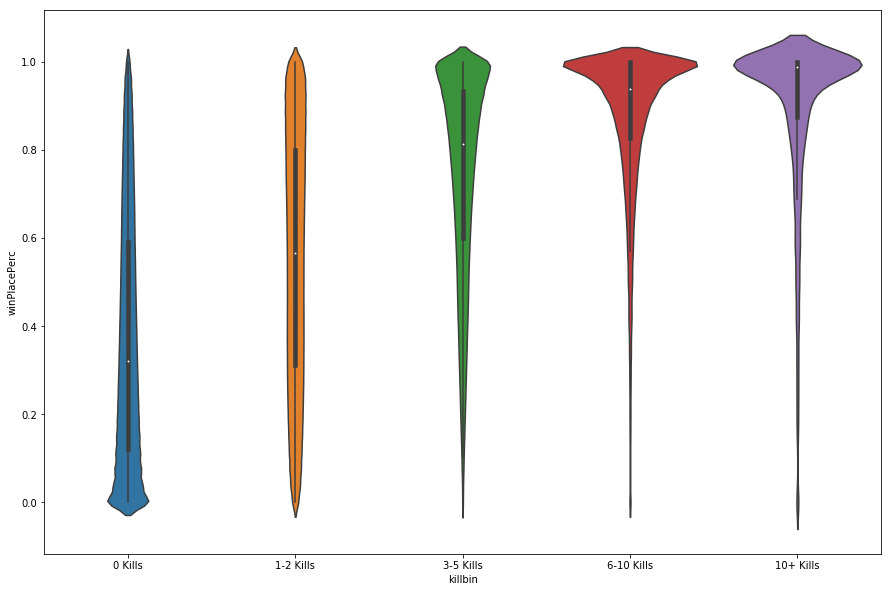

In [22]:
#binning the kill values to explore distribution by bin

data = train.copy()

data['killbin'] = pd.cut(data['kills'], [-1, 0,2, 5,10, 100], labels=['0 Kills','1-2 Kills', '3-5 Kills', '6-10 Kills', '10+ Kills'])

plt.figure(figsize=(15, 10))
sns.violinplot(x='killbin', y='winPlacePerc', data=data)
plt.show()


As expected, for people with 0 kills, the distribution is mostly concentrated around 0 winning percentage,  while the 10+ kills bin have a lot of the population concentrated near the 1 winning percentage. How about the Damage Dealt?

## Dealing some serious Damage. Or not?

In [31]:
print("The average damage dealt by players is: {:.2f}, with {} being the maximum damage dealt. 99% people have dealt {} damage or less.  ".format(train.damageDealt.mean(), train.damageDealt.max(), train.damageDealt.quantile(0.99)))

The average damage dealt by players is: 130.72, with 6616.0 being the maximum damage dealt walked. 99% people have dealt 776.2 damage or less.  


Earlier, we saw most players have zero kills. Do these players inflict some damage atleast?

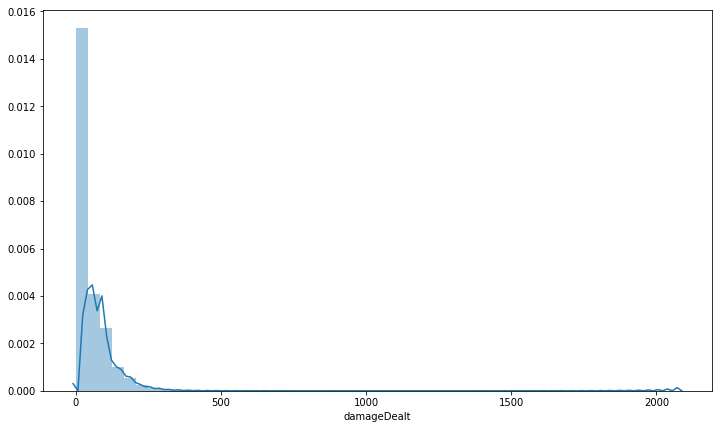

In [27]:
data =train.copy()

data = data.loc[data['kills']==0]

plt.figure(figsize=(12,7))
sns.distplot(data['damageDealt'])
plt.show()

Oh well, most players don't inflict damage either. To explore further, lets plot a Scatter plot and a ViolinPlot similar to the one we plotted for Kills earlier. 

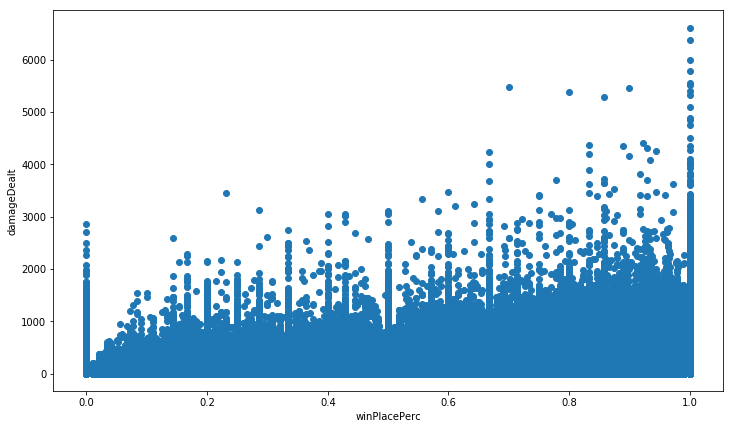

In [33]:
plt.figure(figsize=(12,7))
plt.scatter(x='winPlacePerc', y='damageDealt', data = train)
plt.xlabel("winPlacePerc")
plt.ylabel("damageDealt")
plt.show()

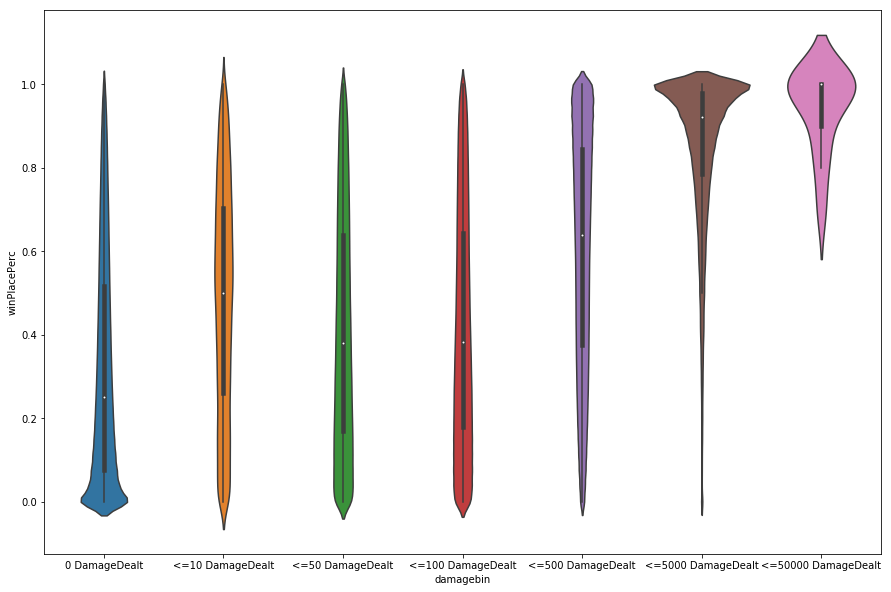

In [32]:
data = train.copy()

data['damagebin'] = pd.cut(data['damageDealt'], [-1, 0, 10, 50,100, 500, 5000, 50000], labels=['0 DamageDealt','<=10 DamageDealt', '<=50 DamageDealt', '<=100 DamageDealt', '<=500 DamageDealt', '<=5000 DamageDealt', '<=50000 DamageDealt'])

plt.figure(figsize=(15, 10))
sns.violinplot(x='damagebin', y='winPlacePerc', data=data)
plt.show()


Similar to the Kills variable, it seems here as well, the more Damage you inflict, the higher your chance of winning. 

## Walking the Walk

In [26]:
print("The average distance players have walked is: {:.2f}m, with {} being the maximum distance walked. 99% people have walked {}m or less.  ".format(train.walkDistance.mean(), train.walkDistance.max(), train.walkDistance.quantile(0.99)))

The average distance players have walked is: 1154.22m, with 25780.0 being the maximum distance walked. 99% people have walked 4396.0m or less.  


Let's see the distribution of walked meters:

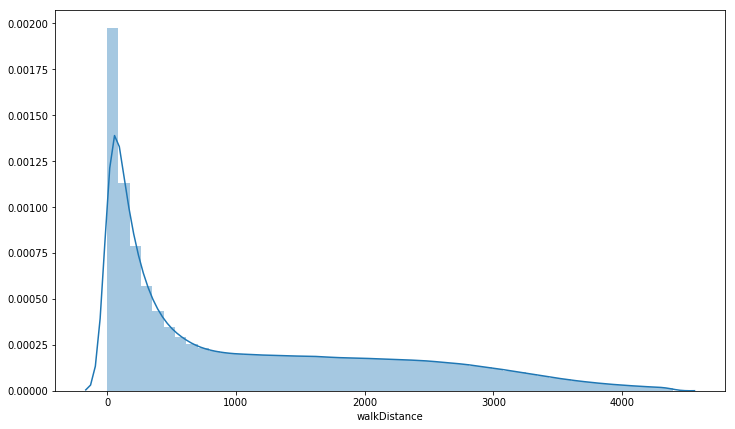

In [36]:
data = train.copy()

#removing the top 1% 
data = data.loc[data['walkDistance'] <= data.walkDistance.quantile(0.99)]
plt.figure(figsize=(12,7))
sns.distplot(data['walkDistance'])
plt.show()

In [38]:
print("{} players ({:.2f}%) walked 0m. That means they died before taking even a single step.".format(len(data.loc[data['walkDistance']==0]),(len(data.loc[data['walkDistance']==0])/len(train))*100 ))

99603 players (2.24%) walked 0m. That means they died before taking even a single step.


<Figure size 864x504 with 0 Axes>

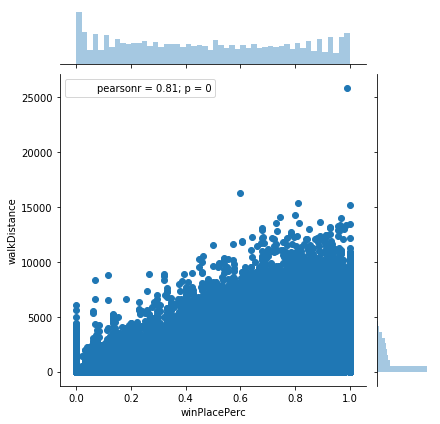

In [39]:
plt.figure(figsize=(12,7))
    
sns.jointplot(x="winPlacePerc", y="walkDistance",  data=train)
plt.show()

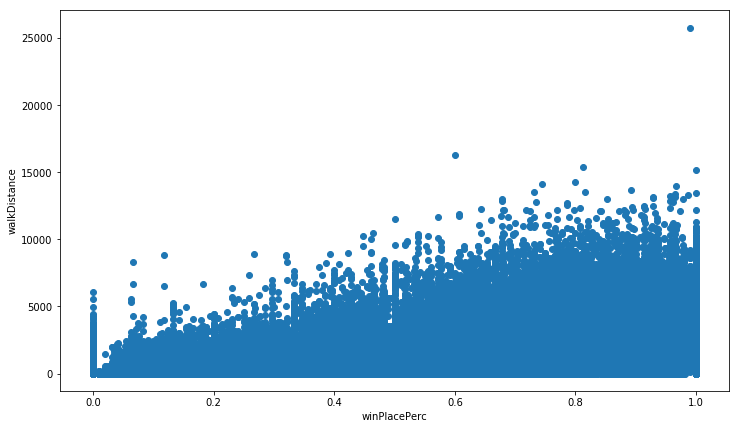

In [40]:
plt.figure(figsize=(12,7))
plt.scatter(x='winPlacePerc', y='walkDistance', data = train)
plt.xlabel("winPlacePerc")
plt.ylabel("walkDistance")
plt.show()

Again, it seems the relation between distance walked and winning is quite high.

[in progress, to be continued...]